## SHRINKAGE METHODS

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

### usiamo i dati engineered con log-price

In [2]:
data=pd.read_csv("Data/aircraft_price_cleaned_log.csv")
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [3]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data

,engine_power,max_speed,cruise_speed,stall_speed,fuel_tank,all_eng_roc,out_eng_roc,takeoff_distance,landing_distance,empty_weight,length,wing_span,range,price
0,4.983607,4.653960,4.521789,46.0,3.610918,6.111467,6.803505,7.170888,7.626083,7.074117,5.717028,6.109248,5.916202,14.077876
1,4.454347,4.499810,4.430817,44.0,2.772589,6.398595,6.580639,6.685861,7.208600,6.710523,5.513429,6.073045,5.252273,14.022526
2,4.510860,4.510860,4.369448,37.0,2.995732,6.478510,6.165418,6.746412,7.170888,6.698268,5.552960,6.042633,5.351858,14.285515
3,4.454347,4.488636,4.369448,37.0,2.995732,6.431331,6.216606,6.746412,7.170888,6.685861,5.552960,6.042633,5.351858,14.077876
4,4.189655,4.430817,4.317488,33.0,2.708050,5.916202,6.450470,6.786717,7.107425,6.608001,5.552960,6.042633,5.170484,14.038655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,6.908755,5.863631,5.814131,56.0,8.248006,8.084254,7.565793,7.732369,9.396903,8.969160,6.257668,6.350886,7.539027,15.226498
503,6.580639,5.746203,5.666427,89.0,6.361302,7.775276,7.732369,8.020928,9.323758,8.830251,6.257668,6.350886,7.451822,15.091990
504,6.580639,5.673323,5.620401,87.0,5.968708,7.712891,8.080547,8.012350,9.323758,8.762490,6.257668,6.350886,7.323831,14.978662
505,6.431331,5.620401,5.602119,77.0,5.948035,7.467942,7.986505,7.802618,9.156412,8.549660,6.089045,6.240276,7.198184,14.991084


In [4]:
# Prepare features and target
X = pd.get_dummies(data.drop('price', axis=1), drop_first=True)
y = data['price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Define lambda values for regularization
lambda_values = np.logspace(-2, 3, 150)

In [5]:
# Create Ridge pipeline with scaling
pipeline = make_pipeline(StandardScaler(), Ridge())

# Grid search for best alpha
param_grid = {'ridge__alpha': lambda_values}
ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best Ridge alpha: {best_alpha}")

Best Ridge alpha: 13.207036227366311


In [6]:
# Evaluate on test set
ridge_best = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f"Ridge Test MSE: {ridge_mse:.2f}")

Ridge Test MSE: 0.02


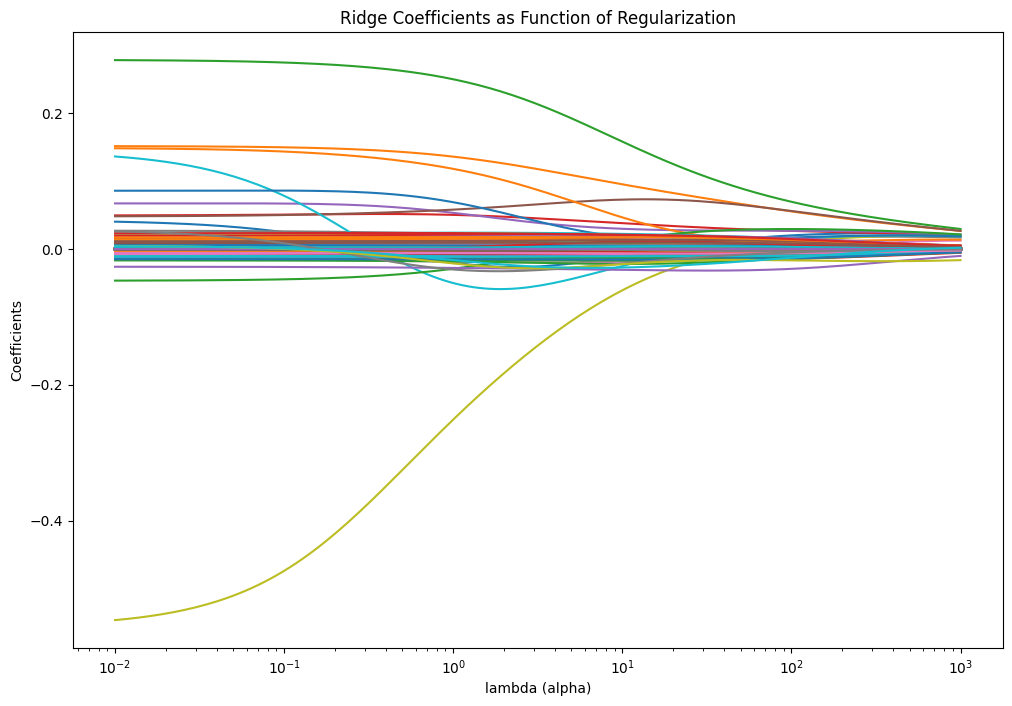

In [7]:
# Plot coefficients vs lambda
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as Function of Regularization')
plt.show()

Stai osservando come Ridge "controlla" i coefficienti al crescere della regolarizzazione: li rende piccoli, ma non li azzera — e questo è esattamente il comportamento previsto.

In [ ]:
# Plot cross-validation errors
cv_scores = []
for alpha in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = -cross_val_score(pipe, X_train, y_train, cv=kf, 
                             scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, cv_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('lambda (alpha)')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Error')
plt.show()

## LASSO 

In [ ]:
# Create Lasso pipeline with scaling
lasso_pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))


# Grid search for best alpha
lasso_cv = GridSearchCV(lasso_pipe, 
                       {'lasso__alpha': lambda_values},
                       scoring='neg_mean_squared_error',
                       cv=10)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['lasso__alpha']
print(f"Best Lasso alpha: {best_alpha}")

Best Lasso alpha: 0.015897992284504753


In [ ]:
# Evaluate on test set
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f"Lasso Test MSE: {lasso_mse:.2f}")

# Number of non-zero coefficients
final_coefs = lasso_best.named_steps['lasso'].coef_
print(f"Number of non-zero coefficients: {np.sum(final_coefs != 0)}")

Lasso Test MSE: 0.03
Number of non-zero coefficients: 16


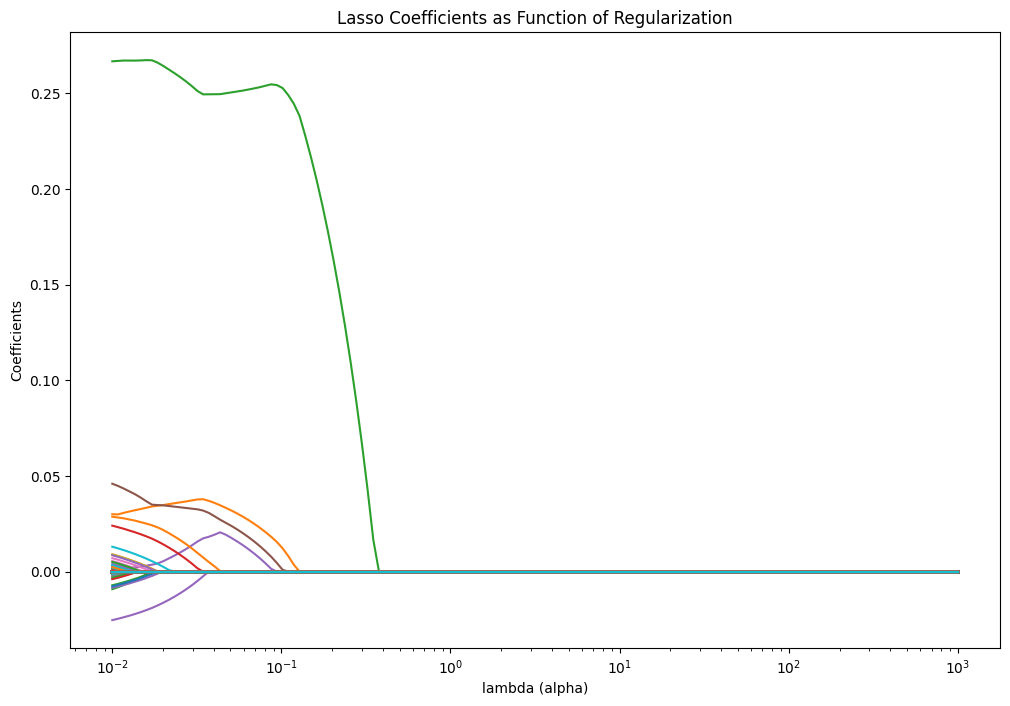

In [ ]:
# Plot Lasso coefficients for different lambda values
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=a, max_iter=10000))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as Function of Regularization')
plt.show()